In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [52]:
train_csv = pd.read_csv('data/train.csv')

In [53]:
# Original work from https://www.kaggle.com/code/ambrosm/mabe-eda-which-makes-sense#EDA-which-makes-sense-for-the-MABe-Challenge---Social-Action-Recognition-in-Mice

class Visualizer():
    """A class for visualizing single frames of mouse videos.

    From https://www.kaggle.com/code/ambrosm/mabe-eda-which-makes-sense
    """
    paws = ['forepaw_left', 'forepaw_right', 'hindpaw_left', 'hindpaw_right']
    head = ['ear_left', 'ear_right', 'nose', 'ear_left']

    def __init__(self, train):
        """Initialize a visualizer.
        
        Parameters:
        train: pandas DataFrame read from train.csv
        """
        self.train = train
    
    def load_video(self, train_idx):
        """Load the specified video into the visualizer"""
        self.train_idx = train_idx
        lab_id = self.train.iloc[train_idx].lab_id
        video_id = self.train.iloc[train_idx].video_id
        path = f"data/train_tracking/{lab_id}/{video_id}.parquet"
        self.video_name = path.split('/')[-1].split('.')[0]
        self.vid = pd.read_parquet(path)
        try:
            self.annot = pd.read_parquet(path.replace('train_tracking', 'train_annotation'))
        except FileNotFoundError:
            self.annot = None
        self.pvid = self.vid.pivot(columns=['mouse_id', 'bodypart'], index='video_frame', values=['x', 'y'])
        self.bodyparts = set(self.pvid.loc[self.pvid.index[0], ('x', 1)].index)
        # print(self.bodyparts)
        self.n_mouses = len(np.unique(self.pvid.columns.get_level_values('mouse_id')))

    def __len__(self):
        """Frame count of video"""
        return len(self.pvid)

    def plot_frame(self, frame_idx):
        """Plot the selected frame of the previously loaded video"""
        video_frame = self.pvid.index[frame_idx]
        if (self.pvid.loc[video_frame] == 0).all():
            print(f"{self.train_idx}.{frame_idx} is empty.")
            return
        for mouse, color in enumerate(['g', 'b', 'orange', 'brown'][:self.n_mouses]):
            mouse_id = mouse + 1
            mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
            my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()

            # Plot the head
            # Every mouse has ear_left and ear_right
            if 'nose' in mx.index and mx['nose'] != 0:
                plt.fill(mx[self.head], my[self.head], color=color, alpha=0.5)
                plt.scatter([mx['nose']], [my['nose']], s=100, color=color)
            else:
                plt.plot(mx[['ear_left', 'ear_right']], my[['ear_left', 'ear_right']], color=color)
            if 'head' not in mx.index:
                mx['head'] = mx[['ear_left', 'ear_right']].mean()
                my['head'] = my[['ear_left', 'ear_right']].mean()

            # Plot the body and tail
            # Every mouse has tail_base, but it can be 0
            parts_list = ['head']
            if 'neck' in mx.index and mx['neck'] != 0:
                parts_list.append('neck')
            if 'body_center' in mx.index and mx['body_center'] != 0:
                parts_list.append('body_center')
            if mx['tail_base'] != 0:
                parts_list.append('tail_base')
            if 'tail_tip' in mx.index and mx['tail_tip'] != 0:
                parts_list.append('tail_tip')
            plt.plot(mx[parts_list], my[parts_list], color=color)

            # Plot the width of the body
            if 'lateral_right' in mx.index:
                plt.plot(mx[['lateral_right', 'lateral_left']], my[['lateral_right', 'lateral_left']], color=color)
                
            # Plot the hip
            if 'hip_right' in mx.index:
                plt.plot(mx[['hip_right', 'hip_left']], my[['hip_right', 'hip_left']], color=color)
                
            # Plot the paws
            if 'forepaw_left' in mx.index:
                plt.scatter(mx[self.paws], my[self.paws], color=color)

        if self.annot is not None:
            # Actions happening in this frame
            actions_in_frame = self.annot[(self.annot.start_frame <= video_frame) &(video_frame <= self.annot.stop_frame)]
    
        if len(actions_in_frame) == 0:
            actions = ''
            agents = ''
            targets = ''
        else:
            # Get all unique actions, agents, targets in this frame
            actions = ','.join(actions_in_frame['action'].unique())
            agents = ','.join(actions_in_frame['agent_id'].astype(str).unique())
            targets = ','.join(actions_in_frame['target_id'].astype(str).unique())
        plt.title(f'{self.train_idx}.{frame_idx} {actions} | Agents: {agents} -> Targets: {targets}')
        plt.gca().set_aspect('equal')
        plt.show()

visualizer = Visualizer(train_csv)

In [54]:
action_list = ['biteobject', 'climb', 'dig', 'exploreobject', 'freeze', 'genitalgroom', 'huddle', 
               'rear', 'rest', 'run', 'selfgroom', 'attack', 'dominance', 'sniff', 'allogroom', 
               'approach', 'attack', 'attemptmount', 'avoid', 'chase', 'chaseattack', 'defend', 
               'disengage', 'dominance', 'dominancegroom', 'dominancemount', 'ejaculate', 'escape', 
               'flinch', 'follow', 'intromit', 'mount', 'reciprocalsniff', 'shepherd', 'sniff', 
               'sniffbody', 'sniffface', 'sniffgenital', 'submit', 'tussle']

C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:32: PerformanceWarning: indexing past lexsort depth may impact performance.
  self.bodyparts = set(self.pvid.loc[self.pvid.index[0], ('x', 1)].index)
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()

Visualizing FIRST occurrence of action: rear


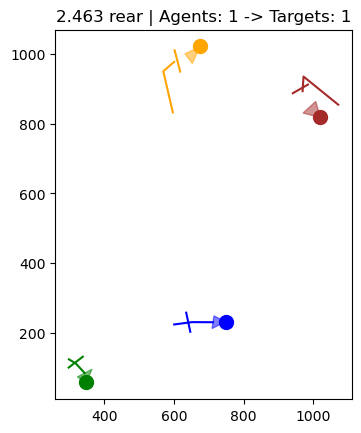

C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\

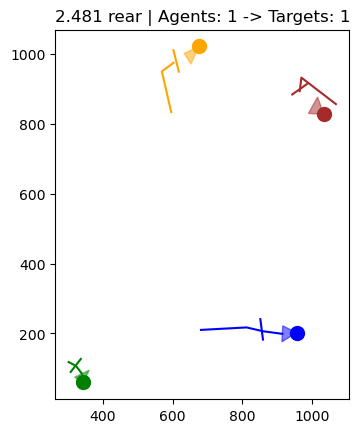

C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\

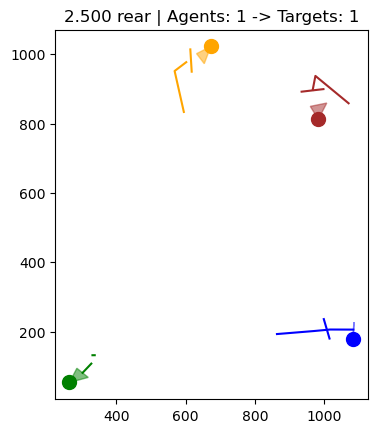

C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\

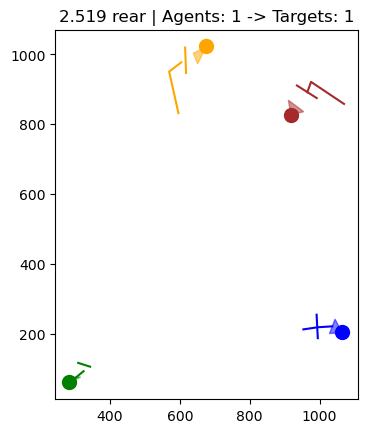

C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\

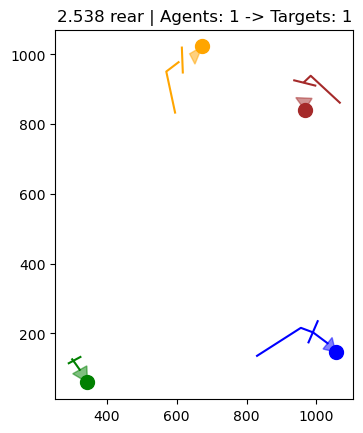

Visualizing FIRST occurrence of action: approach


C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\

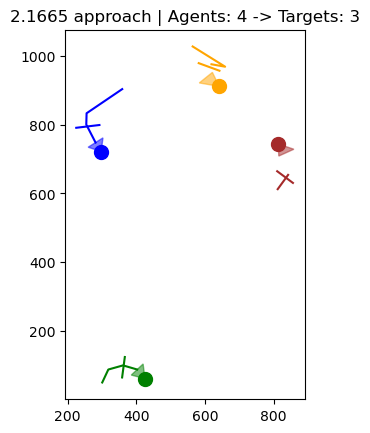

C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\

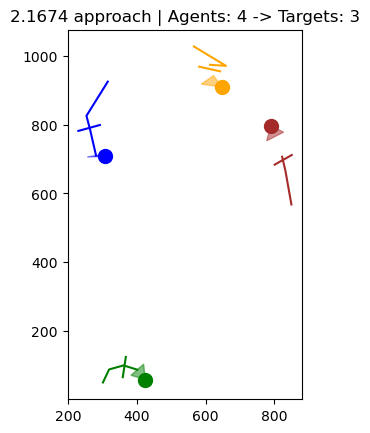

C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\

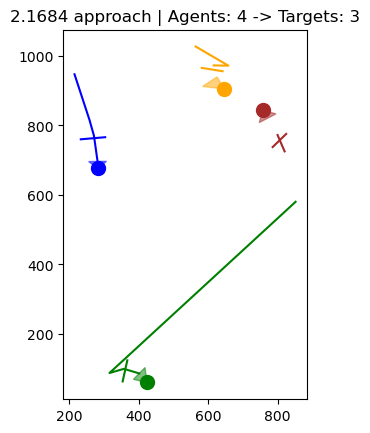

C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\

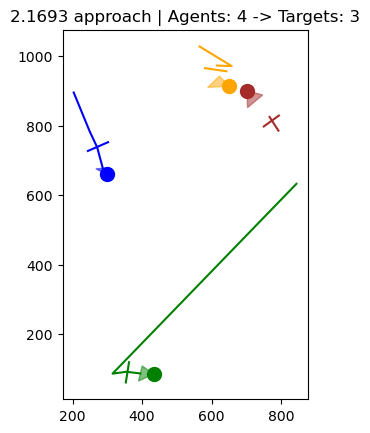

C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\

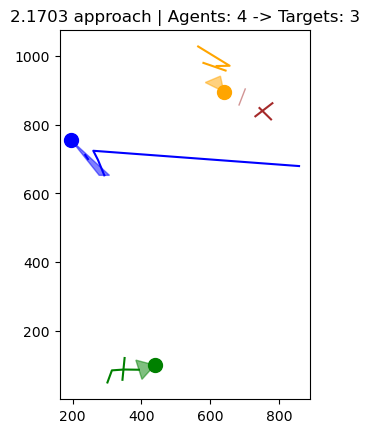

Visualizing FIRST occurrence of action: submit


C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\

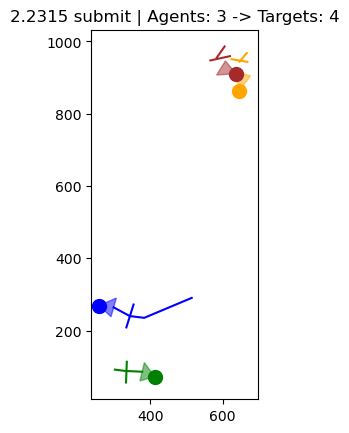

C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\

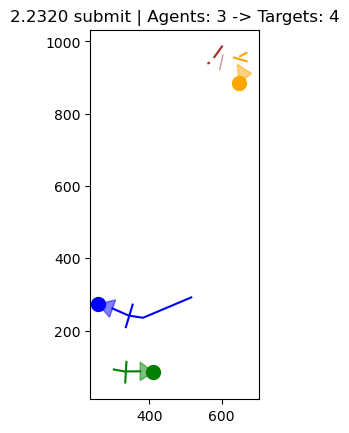

C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\

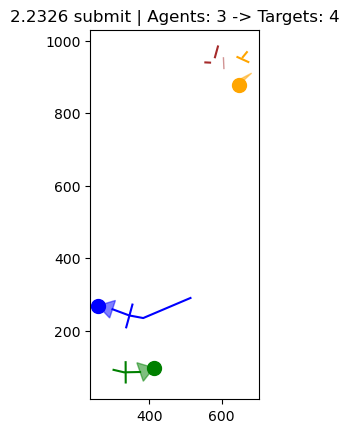

C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\

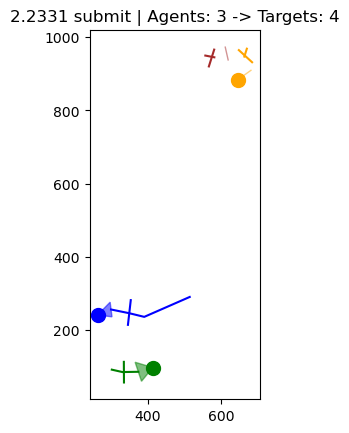

C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\

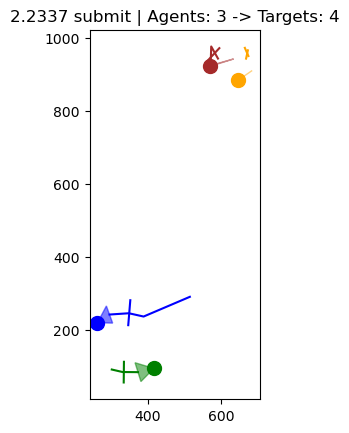

Visualizing FIRST occurrence of action: chase


C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\

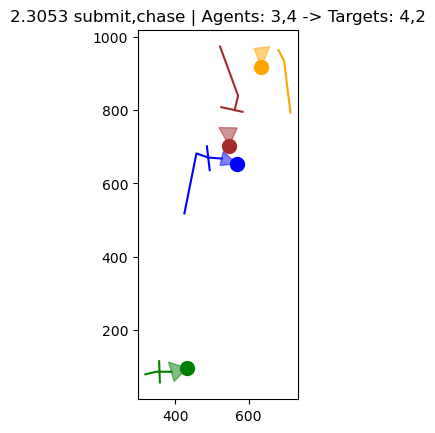

C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\

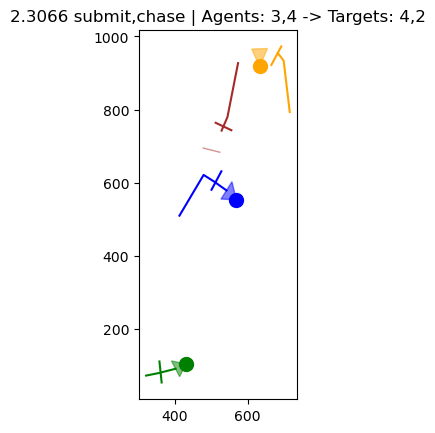

C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\

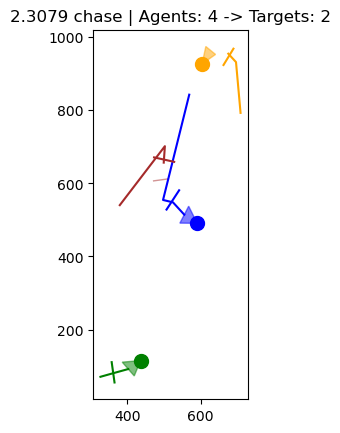

C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\

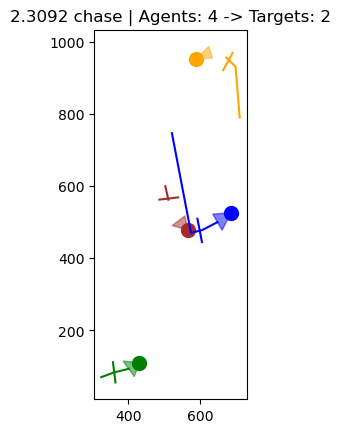

C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\

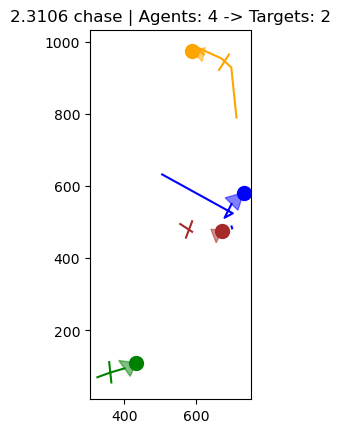

Visualizing FIRST occurrence of action: avoid


C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\

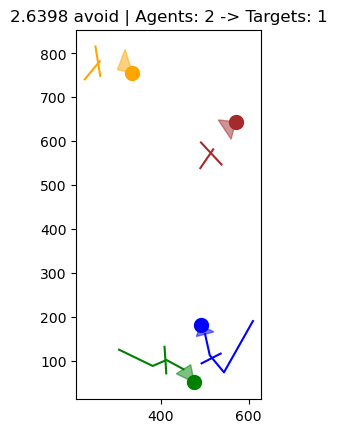

C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\

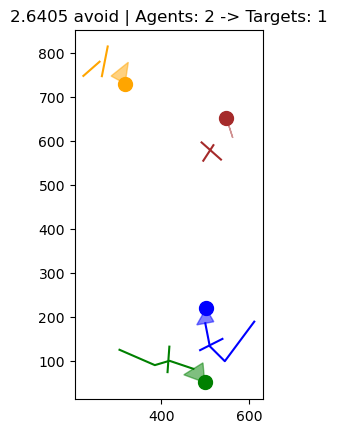

C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\

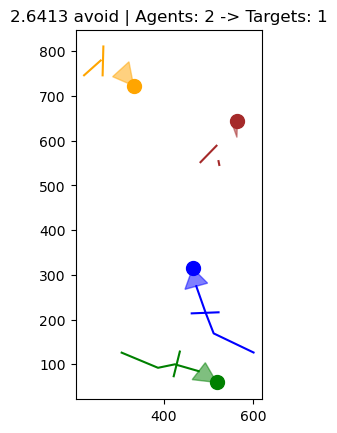

C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\

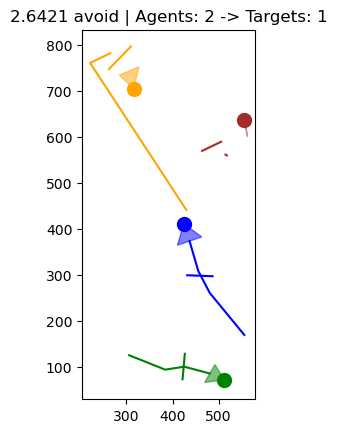

C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\

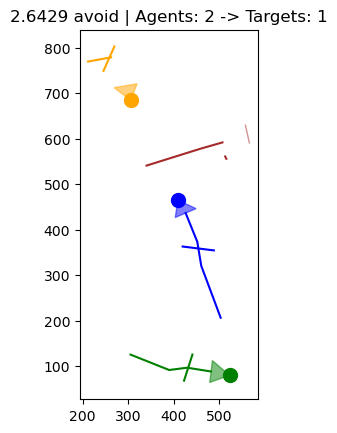

Visualizing FIRST occurrence of action: attack


C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\

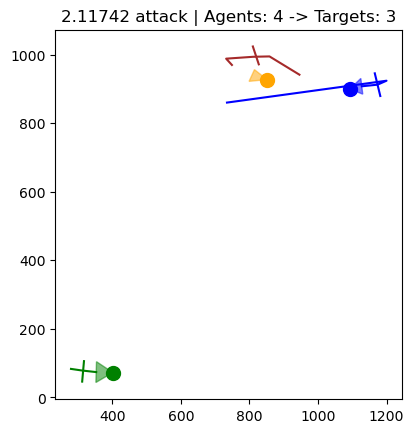

C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\

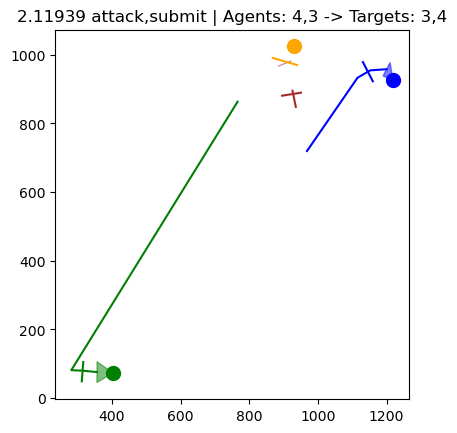

C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\

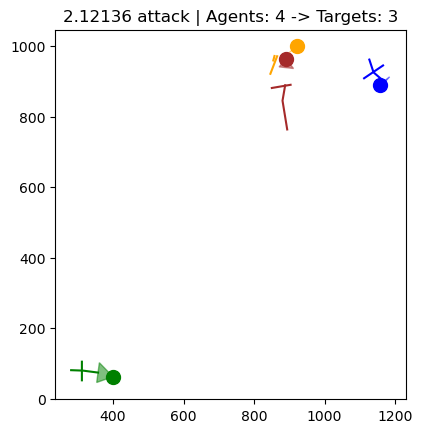

C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\

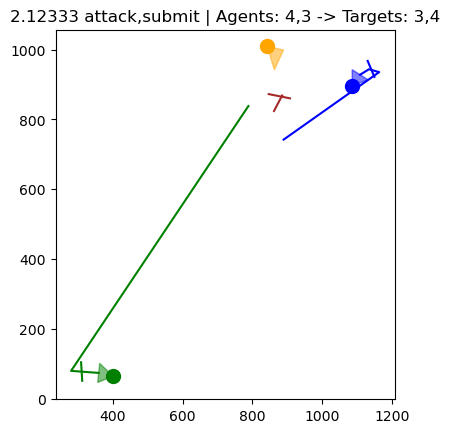

C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\

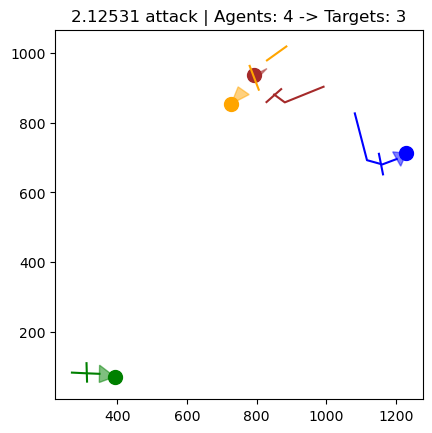

Visualizing FIRST occurrence of action: chaseattack


C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\

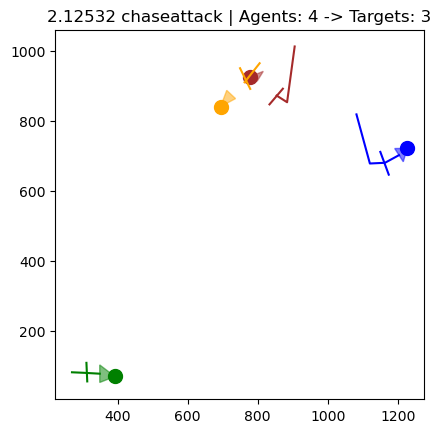

C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\

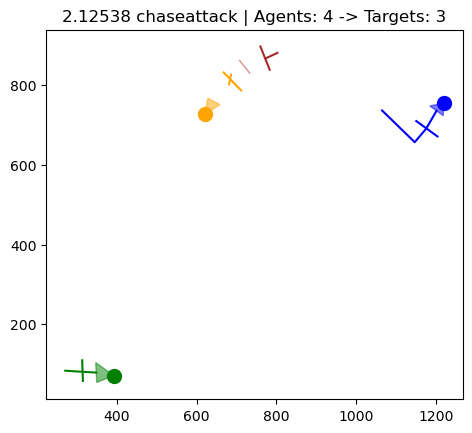

C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\

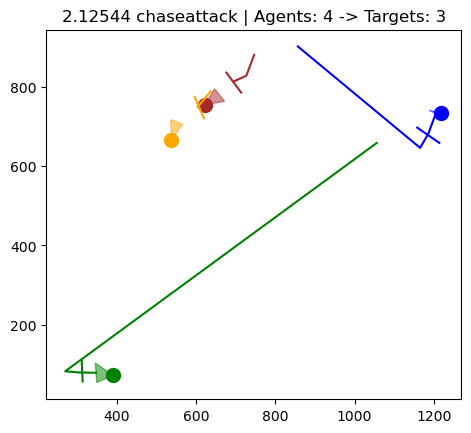

C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\

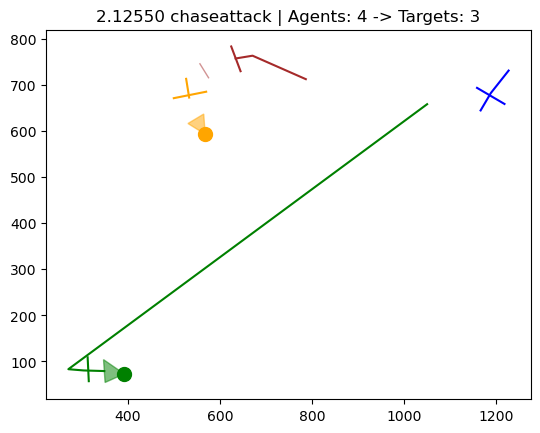

C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  my = self.pvid.loc[video_frame, ('y', mouse_id)].copy()
C:\Users\vunha\AppData\Local\Temp\ipykernel_18556\596091569.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx = self.pvid.loc[video_frame, ('x', mouse_id)].copy()
C:\Users\vunha\

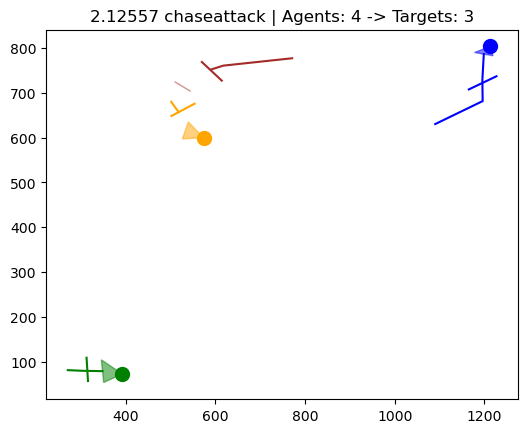

In [55]:
visualizer.load_video(2)
annot = visualizer.annot

# Pick the first occurence of each action only
selected = annot[annot.action.isin(action_list)]

if len(selected) == 0:
    print("No 'rear' action found in this video.")
else:
    # Take first occurrence per action
    first_per_action = selected.groupby('action', sort=False).first().reset_index()

    for _, row in first_per_action.iterrows():
        action = row['action']
        start_f = int(row['start_frame'])
        stop_f = int(row['stop_frame'])

        print(f"Visualizing FIRST occurrence of action: {action}")

        # Sample 5 frames across the action duration
        frames = np.linspace(start_f, stop_f, num=5, dtype=int)

        for f in frames:
            visualizer.plot_frame(f)